In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [3]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func, distinct

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
conn = engine.connect()

In [6]:
# reflect an existing database into a new model
# Declare a Base using `automap_base()`
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect= True)

In [7]:
# We can view all of the classes that automap found
# Print all of the classes mapped to the Base
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
from sqlalchemy.orm import Session
session = Session(bind=engine)

In [22]:
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


# Exploratory Climate Analysis

## Precipitation Analysis

In [23]:
# Calculate the date 1 year ago from the last data point in the database
last_date = engine.execute('SELECT MAX(date) FROM measurement')
for r in last_date:
    print(r)

# or

lastDate = session.query(func.max(Measurement.date))
for d in lastDate:
    print(d)

# or

L_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
L_date

('2017-08-23',)
('2017-08-23',)


('2017-08-23')

In [24]:
# 1 year ago
aYear_ago = dt.date(2017,8,23) - dt.timedelta(days=365)
print(aYear_ago)

2016-08-23


In [25]:
# Design a query to retrieve the last 12 months of precipitation data
prcp_results = session.query(Measurement.date, Measurement.prcp).\
        filter(Measurement.date >= '2016-08-23')

In [26]:
# Load the query results into a Pandas DataFrame and set the index to the date column
prcp_results_df = pd.DataFrame(prcp_results, columns = ['date', 'precipitation'])
prcp_results_df.set_index('date', inplace=True)
prcp_results_df = prcp_results_df.sort_index()

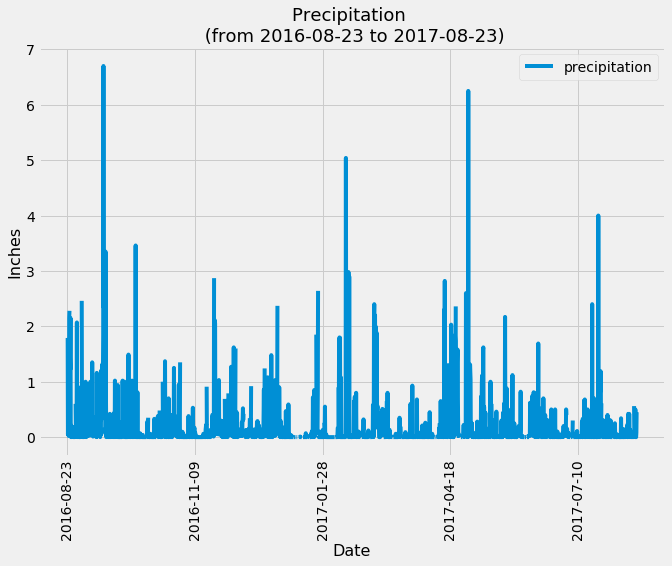

In [27]:
# Use Pandas Plotting with Matplotlib to plot the data

prcp_results_df.plot(rot=90, figsize=(10,7))
plt.title("Precipitation \n (from 2016-08-23 to 2017-08-23)", fontsize=18)
plt.ylabel("Inches", fontsize=16)
plt.xlabel("Date", fontsize=16)

plt.tight_layout
plt.savefig("Images/Prcp_12month.png")
plt.show()

In [28]:
# the summary statistics for the precipitation data
prcp_results_df.describe() 

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


Average precipitation over the last 12 months is 0.177 inches.

Minimum precipitation over the last 12 months is 0 inches.

Maximum precipitation over the last 12 months is 6.7 inches.

## Station Analysis

In [29]:
# Design a query to show how many stations are available in this dataset?
num_stations = session.query(distinct(Measurement.station)).count()
print(f"Number of stations in the data set : {num_stations}")

Number of stations in the data set : 9


In [30]:
#List the stations and observation counts in descending order.
print(f"( Station #,  Observation counts)")
station_list_count= session.query(Measurement.station, func.count(Measurement.station)).\
group_by(Measurement.station).order_by(func.count(Measurement.station).desc())
for station in station_list_count:
    print(station)

( Station #,  Observation counts)
('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


In [31]:
most_active = station_list_count.first()
print(f"Most active station and its observation count : {most_active}")

Most active station and its observation count : ('USC00519281', 2772)


In [32]:
# Design a query to retrieve the last 12 months of temperature observation data (TOBS).
mActive_last_12mo = session.query(Measurement.station, Measurement.date, \
                                  Measurement.prcp, Measurement.tobs).\
                            filter(Measurement.station == 'USC00519281').\
                            filter(Measurement.date >= '2016-08-23')

In [33]:
#Load the query results into a Pandas DataFrame.
df=pd.DataFrame(mActive_last_12mo, columns=['Station','Date', 'Precipation', 'Temperature'])

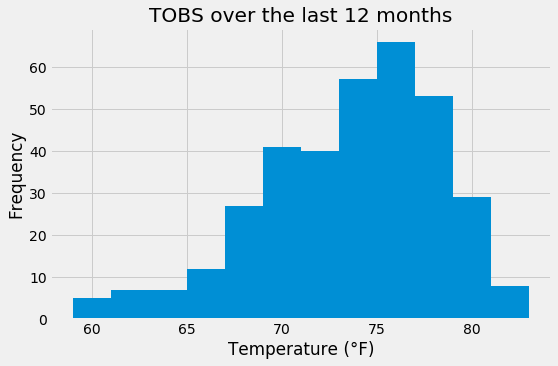

In [34]:
#Plot the results as a histogram with bins=12.
plt.figure(figsize=(8,5))
plt.hist(df['Temperature'], bins =12)
plt.title('TOBS over the last 12 months')
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')
plt.tight_layout
plt.savefig("Images/Temp_hist.jpg")
plt.show()

#  Climate App

In [57]:
# Use Flask to create your routes.
# Convert the precipitioan query results to a dictionary using date as the key and prcp as the value.
List_dict_prcp = prcp_results_df.to_dict()

# Query station data > load to dataframe > convert to dictionary 
station_data = session.query(Station.station, Station.name, Station.latitude,\
                             Station.longitude, Station.elevation).all()
station_df = pd.DataFrame(station_data, columns = ['station', 'name', 'latitude',\
                                                   'longitude', 'elevation'])
List_dict_station = station_df.to_dict()

# Queried tobs data to dictionary 
tobs_df = df[['Date', 'Temperature']]
tobs_df.set_index('Date', inplace=True)
List_dict_tobs = tobs_df.to_dict()

In [62]:
# Use Flask to create your routes.
# 1. import Flask
from flask import Flask, jsonify

List_dict_prcp
List_dict_station
List_dict_tobs

# 2. Create an app, being sure to pass __name__
app = Flask(__name__)

# 3. Home page
@app.route("/")
def home():
    return (
        f"Welcome to Climate Home page !<br/>"
        f"Part 3 of the Homework"
        )

# 4. precipitation
@app.route("/api/v1.0/precipitation")
def prcp():
    return jsonify(List_dict_prcp)

# 5. stations
@app.route("/api/v1.0/stations")
def station():
    return jsonify(List_dict_station)

# 6. TOBS
@app.route("/api/v1.0/tobs")
def tobs():
    return jsonify(List_dict_tobs)


# 7. start 
"""
@app.route("/api/v1.0/<start>")
def start():
    TMIN, TAVG, and TMAX for all dates greater than and equal to the start date
    return TMIN, TAVG, TMAX

# 7. start & end 
@app.route("/api/v1.0/<start>/<end>")
def start():
    TMIN, TAVG, and TMAX for dates between the start and end date inclusive
    return TMIN, TAVG, TMAX
"""
if __name__ == "__main__":
    app.run(debug=True)

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on


 * Restarting with windowsapi reloader


SystemExit: 1

C:\Users\JJ\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3339: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


# Bonus Challenge Assignment

In [14]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [15]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [16]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [17]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [18]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [19]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [20]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [21]:
# Plot the daily normals as an area plot with `stacked=False`
